In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Opening 

#### Recap: we made a simple classifier last week with dogs and cats.

How do we tune these neural networks? Learning rate. Practice. Epoch number


#### Simple Code
```python

arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)
```

#### Output
```python
A Jupyter Widget
[ 0.       0.04726  0.02807  0.99121]                          
[ 1.       0.04413  0.02372  0.99072]                          
[ 2.       0.03454  0.02609  0.9917 ]                         


```


In [4]:
PATH = "/home/paperspace/Desktop/data/dogscats/"
sz=224
arch=resnet34

In [5]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [6]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

A Jupyter Widget

[ 0.       0.04247  0.02314  0.9917 ]                          
[ 1.       0.03443  0.02482  0.98877]                          
[ 2.       0.03072  0.02676  0.98975]                          



## Choosing a learning rate

The thing that most determines how we are going to zoom in or home in on the solution. Were is the "minimum point". How do you find the minimum point?

If i was a computer algorithm, how do i found the minimum. The learning rate is how big of a jump that we will advance ( the size of the arrow in teh image below)

![](https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization_files/ball.png)

### If your learning rate is too high:

![](https://4.bp.blogspot.com/-ZZShOqXdvcU/U3WoCBG7nhI/AAAAAAAAF5o/r54-OQW1aBk/s1600/8.png)

### Learning rate finder 

```python
learn = ConvLearner.pretrained(arch, data, precompute=True)
```

This is custom function

### The ConvLearner Class
```python
 def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        self.crit = F.binary_cross_entropy if data.is_multi else F.nll_loss
        if data.is_reg: self.crit = F.l1_loss
        elif self.metrics is None:
            self.metrics = [accuracy_multi] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    @classmethod
    def pretrained(self, f, data, ps=None, xtra_fc=None, xtra_cut=0, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg, ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut)
        return self(data, models, **kwargs)

    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data):
        super().set_data(data)
        self.save_fc1()
        self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations

        if len(self.activations[0])==0:
            m=self.models.top_model
            predict_to_bcolz(m, self.data.fix_dl, act)
            predict_to_bcolz(m, self.data.val_dl, val_act)
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self): self.freeze_to(-self.models.n_fc)
```

## The Fastai library does:

- uses the adam optimizer
- fastai tries to find the fastest way to converge to a solution.

#### Best thing to do for your model is get more data:

Problem: models will eventually start memorizing answers, this is called overfitting. Ideally more data will prevent this occurance. There's other techniques to assist with gathering more data.

#### Data augmentation (lesson 1)

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

#### Transformations library

Can use the options to change the options, zoom, rotate and shift

In [7]:
tfms = tfms_from_model(resnet34, 
                       sz, 
                       aug_tfms=transforms_side_on, 
                       max_zoom=1.1)

In [8]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [9]:
ims = np.stack([get_augs() for i in range(6)])

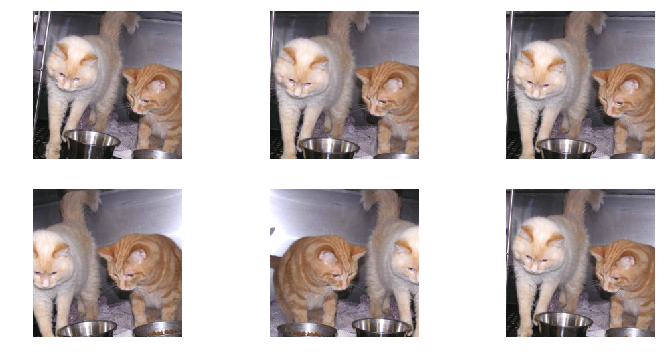

In [10]:
plots(ims, rows=2)

#### Other Options
    transforms_side_on
    transforms_top_down

![](https://qph.ec.quoracdn.net/main-qimg-4dae1c1d85a3fec86cdd76dbb642c027-c)

### Why do we use the learning rate that isn't the lowest point?

Each time we iterate, we will double the learning rate. The purpose of this to find what learning rate is helping use to decrease quickly. The learning rate is going too high. 

![](http://cs231n.github.io/assets/nn3/learningrates.jpeg?w=240)

### Comment: this augmentation won't doing anything because of precompute

Note, we are using a pretrained network. We can take the 2nd last layer and save those activations. There is this level of "dog space" "eyeballs" etc. We save these and call these pre-computed activations.

#### Activations - is a number. This feature is in this location with this level of confidence and probability

#### Making a new classifier from precompute
We can quickly train a simple linear model based on these saved precomputed numbers. So the first time you run a model, it will take some time to calculate and compile. Then afterwards, it will train much faster.



In [11]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

A Jupyter Widget

[ 0.       0.04783  0.02601  0.99023]                          



Since we have precomputed the different cat pictures don't help. So we will turn it off.

By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.


In [12]:
learn.precompute=False
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.0472   0.0243   0.99121]                         
[ 1.       0.04335  0.02358  0.99072]                         
[ 2.       0.04403  0.0229   0.99219]                         



## Cycle Length = 1

### As we get closer, we may want to decrease the learning rate to get a more precise. AKA annealing.

#### Most common annealing: 
pick a rate, then drop it 10x, then drop again. Stepwise, very manual. A simpler approach is to choose a functional form such as a line. Turns out that half a cosine curve works out well.


##### What do you do when you have more than one minima?

Sometimes one minima will be better than others (based on how well it generalizes). So sharply changing the learning rate has the idea that if we suddenly jump up the learning rate, we will get out of "narrow" minimum and find the most "generalized" minimum.

![](https://cdn-images-1.medium.com/max/1200/1*S3NpdnSPHmfIURoLU-NuDg.png)

#### Note that annealing is not necessarily  the same as restarts

We are not starting from scratch each time, but we are 'jumping' a bit to ensure we are in the best minima.


##### From the lesson 2 notebook:
What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

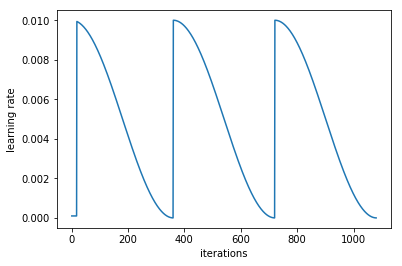

In [13]:
learn.sched.plot_lr()


#### Good Tip: Save your weights as you go!

```python
learn.save('224_lastlayer')
```

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [15]:
learn.unfreeze()


#### In general you can only freeze layer from 'n' and on

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

### Specifying learning rates

We are going to specify 'differential learning rates' for different layers. We are grouping the blocks (RESNET blocks) in different areas and assigning different learning rates.

Reminder: we unfroze the layers and now we are retraining the whole set. The learning rate is smaller for early layers and making them larger for the ones farther away

In [16]:
lr=np.array([1e-4,1e-3,1e-2])

In [17]:
# 3 is the number of cycles
# 3 cycles of 2 epochs
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.04913  0.02252  0.99268]                         
[ 1.       0.04842  0.02123  0.99219]                         
[ 2.       0.03309  0.02412  0.99121]                         
[ 3.       0.03528  0.02148  0.99072]                         
[ 4.       0.02364  0.02106  0.99023]                         
[ 5.       0.01987  0.01931  0.9917 ]                         
[ 6.       0.01994  0.02058  0.99121]                         



#### cycle_mult parameter

Doubles the length of the cycle after each cycle

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

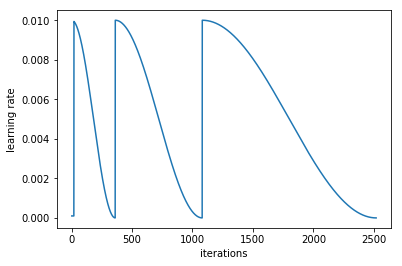

In [18]:
learn.sched.plot_lr()

#### At this point, we are going to look back at incorrect pictures

We are going to do. Use **test time augmentation** we are going to take 4 random data augmentation. Move them around and flip and mix with the prediction. We are going to average all the predictions of the original + permutation. Ideally the rotating + zoom will get it in the right orientation

#### TTA() - makes predictions not only on the originals but also on the random augmented generated

In [19]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

0.99199999999999999